Homework 6: Random forests
==========================
### Author: Calvin Henggeler
### Dataset: Wine Quality
https://archive.ics.uci.edu/dataset/186/wine+quality
Starting notebook: 312_2023-10-27.ipynb

1) Begin from the notebook from 10/27. We created a random forest which dropped random columns and got pretty good performance. We then tried random subspace projection with mediocre results. Next, we tried using normalization and PCA with random subspace projection, and the results still were not great. Try combining normalization and PCA with dropping random columns.
2) In class on 10/30, we combined row bootstrapping with dropping random columns to make a random forest. Try this again, varying the size of your bootstrap sample from 100 to 10000 (or larger if you see reason to do so). Graph model accuracy vs size of bootstrap sample.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
rand_state = 420

In [2]:
# combine red and white data sets
df_red = pd.read_csv('../data/winequality-red.csv',sep = ';')
df_red['color'] = 1
df_white = pd.read_csv('../data/winequality-white.csv',sep = ';')
df_white['color'] = 0
df = pd.concat([df_red,df_white])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


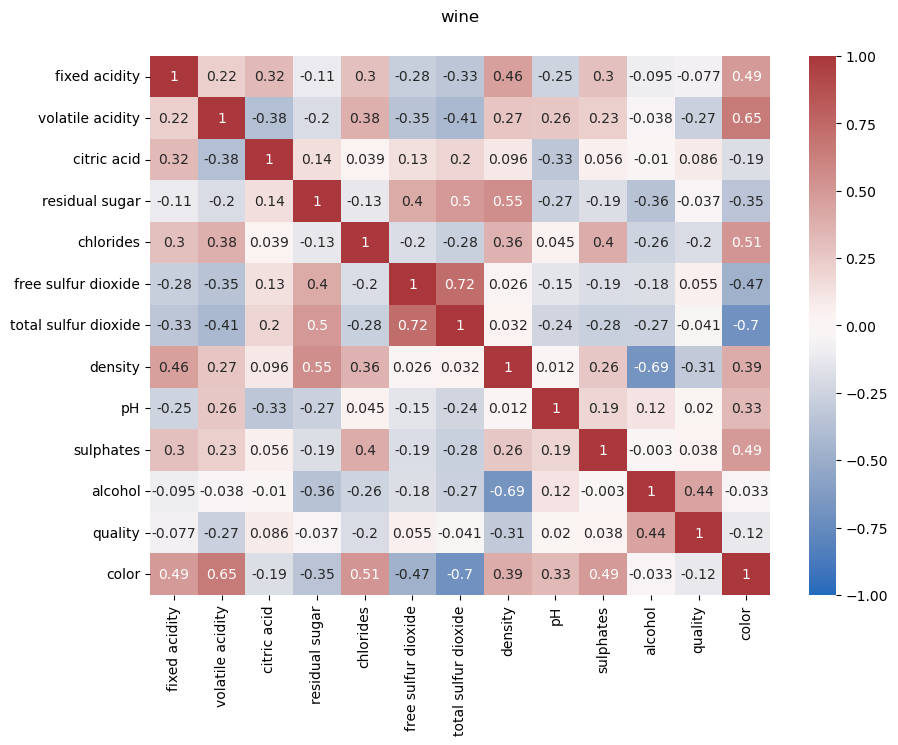

In [4]:
fig,ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1,cmap='vlag',annot=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation =90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('wine', pad = 25);

We'll predict target: quality using the other columns as features.

In [3]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color']
target = ['quality']

In [4]:
# Train 80% | Validation 20% | Test 20%
x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       train_size = 0.8)
x_tr,x_va,y_tr,y_va = train_test_split(x_tr,y_tr,
                                       train_size = 0.5)

We check the accuracy of an unrestricted tree.

In [15]:
tr = DecisionTreeRegressor(random_state = rand_state)
tr.fit(x_tr,y_tr)
print(f'Train score: {tr.score(x_tr,y_tr)}')
print(f'Val score: {tr.score(x_va,y_va)}')

Train score: 1.0
Val score: -0.1490027554907205


First, we attempt to create an ensemble from a bunch of unrestricted trees.

In [16]:
# create a collection of 100 trees
np.random.seed(0)
trees = []
for i in range(100):
    tr = DecisionTreeRegressor(random_state = rand_state)
    trees.append(tr)

In [17]:
# train each tree
for tr in trees:
    tr.fit(x_tr,y_tr)

We need a function which, given a forest and some inputs (feature data), will generate predictions. It should do this by getting the prediction for each tree then averaging the results. We can imagine slight tweaks to this approach, such as taking the mean of the middle 80% of predictions.

In [18]:
def forest_pred(forest,inputs):
    '''
    accepts: forest: a collection of trees
             inputs: the feature data
    returns: an array of predictions gotten by averaging the predictions per tree
    '''
    preds = [tree.predict(inputs) for tree in forest] # make prediction per tree
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

def score(preds,actual):
    '''
    accepts: preds: an iterable of predictions
             actual: the actual values
    returns: the R^2 score of the model which generated the predictions
    '''
    resid = actual - preds.reshape(-1,1)
    sse = np.sum(resid**2)
    resid_null = actual - np.mean(actual)
    sse_null = np.sum(resid_null**2)
    r2 = 1-sse/sse_null
    return(r2)

So, let's see how accurate our forest is.

In [19]:
preds = forest_pred(trees, x_va)
score(preds,y_va)

C:\repos\DS312\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


quality   -0.149003
dtype: float64

This didn't turn out so great. Why is that? The trees are all basically the same, so when they are wrong (overfit), the are wrong (overfit) in the same way.

### Select Random Features per Tree

Like a good Who Wants to be a Millionaire audience, we want these bad trees to make errors which are uncorrelated with each other. One way to reduce correlation among the errors is to train each tree on a random subset of the feature set. We can imagine other interventions (which would be less straightforward to code), such as at each node randomly forcing a tree to ignore a subset of the features. It would be interesting to see a comparison of different approaches to disrupting tree correlation.

In [24]:
print(features)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


In [25]:
# I want to get random subsets of features
np.random.randint(0,2,len(features)) # gets a random array of 0s and 1s of length 12

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [26]:
# convert from binary to boolean
[bool(x) for x in np.random.randint(0,2,len(features))]

[False, False, False, False, True, False, True, False, True, True, True, True]

In [34]:
# I can subset a np array with a boolean vector
print(features)
np.array(features)[[bool(x) for x in np.random.randint(0,2,len(features))]]

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


array(['citric acid', 'residual sugar', 'sulphates', 'color'],
      dtype='<U20')

In [43]:
fs = np.array(features)[[bool(x) for x in np.random.randint(0,2,12)]]
df[fs].columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'color'],
      dtype='object')

We need a list of feature sets for the trees to be trained on. We must store this information, because when we make predictions, for each tree, we must isolate the same feature subset that tree was trained on. If we store the feature names, we can only accept inputs which include the feature names. If we store the binary, we can only accept inputs whose features are in the correct order, and if the feature names are not supplied, the user could unknowingly get an incorrect result. It is therefore safest to insist on feature names being supplied.

In [21]:
num_trees = 100
fss = [] # a list to hold the list of feature subsets
for i in range(num_trees):
    # we need a random binary array with not all 0s
    array = [0]
    while sum(array)==0:
        array = np.random.randint(0,2,12)
    fs = np.array(features)[[bool(x) for x in np.random.randint(0,2,12)]]
    fss.append(df[fs].columns)

In [27]:
np.random.seed(0)
trees = []
for i in range(num_trees):
    tr = DecisionTreeRegressor(random_state =  np.random.randint(2**10))
    x_tr_subset = x_tr[fss[i]] # get the subset of the training set according to fs
    tr.fit(x_tr_subset,y_tr)
    trees.append(tr)

In [23]:
def forest_pred(forest,inputs,fss):
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(inputs[fs]))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

Let's make predictions. Let's remember that each tree here will be worse on average than before, since each tree is given only a subset of the available data.

In [28]:
preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

C:\repos\DS312\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


quality    0.432771
dtype: float64

### Sklearn Built in Random Forest Model

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rfr = RandomForestRegressor()
rfr.fit(x_tr,y_tr)
rfr.score(x_va,y_va)

/home/calvin/.local/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.41954489119915217

We can see some details about the random forest.

### Random Subspace Projection

We'll try to improve on what we've done. You may recall from our discussion of PCA: sometimes we can take a dataset and project it onto a subspace. For example, applying PCA with $k$ components to a dataset with $n\geq k$ features involves projecting the dataset onto a subspace of dimension $k$.

Here, when we drop some features, we're really just projecting onto a subspace of the dataset. Dropping features is a very special case of projecting onto a subspace. We can try other means of projecting onto subspaces, with an eye towards further reducing correlation between individual trees.

Our first attempt will be: randomly select $k$ with $1 \leq k \leq 12$ (where 12 is the number of features), then randomly generate an orthonormal 12-by-$k$ matrix, and use this effect a projection of the data onto a random subspace. As before, we'll have a different projection for each tree, and we must be able to recall those projections when we make predictions. So, these random matrices are stored.

In [29]:
''' Example: generating a random 12-by-k orthogonal matrix.
    The so-called QR-factorization of X will Gram-Schmidt it.
    To be safe, I suppose we should see what happens when we try to QR a matrix with
    linearly dependent columns, and if that raises an exception, use try/except.
'''
k = np.random.randint(1,13)
X = np.random.uniform(-1,1,k*12).reshape(-1,k)
X,_ = np.linalg.qr(X) # gram-schmidt X
np.random.shuffle(X.T) # in case the columns aren't random, shuffle them.
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,0.256348,-0.065028,0.292110,-0.144617,0.467846,0.050801,-0.426487,0.617166,-0.111693,-0.033217
1,0.132297,-0.413269,-0.268912,0.294478,-0.287791,0.634683,-0.149678,0.134341,-0.158901,0.104153
2,-0.151722,-0.619538,-0.243786,0.174958,0.185993,-0.471775,0.349444,0.221603,-0.020696,0.031779
3,0.221289,-0.210829,0.276367,0.060541,0.295504,0.197764,0.351553,-0.201622,-0.404001,0.350444
4,-0.470795,0.048320,-0.003738,0.061546,0.034260,-0.233469,-0.453346,-0.104867,-0.305942,0.603419
5,-0.491923,-0.046243,-0.072046,-0.191199,0.516323,0.353596,0.064326,-0.262552,-0.193232,-0.404535
6,-0.322104,0.149469,-0.214729,0.148534,-0.248045,-0.004124,-0.046940,0.377078,-0.447282,-0.313481
7,-0.003450,0.284380,-0.192302,-0.080324,0.030176,0.243805,0.147531,-0.026818,-0.036071,0.350278
8,0.065321,-0.074425,-0.028577,-0.778173,-0.326459,-0.057189,0.230229,0.153279,-0.362637,0.067191
9,-0.212425,-0.492789,0.026858,-0.388461,-0.122632,0.134162,-0.331466,-0.139178,0.388797,0.049878


In [30]:
num_trees = 100
trees = []
fss = []
for i in range(num_trees):
    k = np.random.randint(1,13)
    fs = np.random.uniform(-100,100,k*12).reshape(-1,k)
    fs,_ = np.linalg.qr(fs) # gram-schmidt X
    np.random.shuffle(fs.T) # in case the columns aren't random, shuffle them.
    fss.append(fs)
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**10))
    tr.fit(np.matmul(x_tr,fs),y_tr)
    trees.append(tr)

def forest_pred(forest,inputs,fss):
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(np.matmul(inputs,fs)))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

In [31]:
preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

C:\repos\DS312\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


quality    0.294264
dtype: float64

### Normalization and PCA with Random Subspace Projection
It looks to be less accurate than dropping random features. Let's try normalizing then PCA before random subspace projection.

In [32]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [34]:
pca = PCA()
pca.fit(normalize(x_tr))
x_tr_p = pca.transform(normalize(x_tr))

num_trees = 100
trees = []
fss = []

for i in range(num_trees):
    k = np.random.randint(1,13)
    fs = np.random.uniform(-100,100,k*12).reshape(-1,k)
    fs,_ = np.linalg.qr(fs) # gram-schmidt X
    np.random.shuffle(fs.T) # in case the columns aren't random, shuffle them.
    fss.append(fs)
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**10))
    tr.fit(np.matmul(x_tr_p,fs),y_tr)
    trees.append(tr)

def forest_pred(forest,inputs,fss):
    inputs = pca.transform(normalize(inputs))
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(np.matmul(inputs,fs)))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

C:\repos\DS312\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


quality    0.307357
dtype: float64

## 1) Normalization and PCA w/ Dropping Random Columns

In [37]:
pca = PCA()
pca.fit(normalize(x_tr))
x_tr_p = pca.transform(normalize(x_tr))     # normalized & PCA feature set
x_tr_p[:10]

array([[-4.91207908e-02, -1.17571651e-01, -2.92540082e-02,
        -1.71372563e-02, -7.95504990e-03,  2.12961590e-03,
         5.62542681e-03,  1.00108144e-03,  1.92887539e-03,
         1.40528758e-03, -1.80201214e-04,  4.35781123e-04],
       [ 1.60323942e-01,  1.64616419e-01,  2.16052696e-02,
         7.60132634e-02, -1.52445523e-02, -3.69575683e-03,
         9.02575671e-04, -2.98453786e-03, -1.20214495e-03,
        -7.49376807e-04, -1.52195121e-04,  9.04616247e-05],
       [ 1.39871577e-01,  1.78445264e-02, -2.37372650e-02,
        -1.06280180e-03, -4.04518033e-02,  1.22201736e-02,
        -3.23254591e-04, -3.65826129e-04,  8.55813948e-04,
        -2.10892055e-03, -2.20400979e-04,  4.52729000e-04],
       [-9.27341037e-02,  3.40183798e-03, -3.22787469e-02,
        -3.05820814e-03,  9.72660199e-03, -2.88395977e-03,
        -3.78422791e-04, -2.06628184e-03, -5.44785991e-04,
         1.35069201e-05,  1.32025997e-04, -7.85014618e-05],
       [ 5.72570481e-01, -3.81964787e-02, -3.0199252

In [46]:
num_trees = 100
trees = []      # list to hold trees (the forest)
fss = []        # list to hold feature subsets

for i in range(num_trees):
    # we need a random binary array with not all 0s (ensures no empty feature set)
    array = [0]
    while sum(array)==0:
        array = np.random.randint(0,2,12)
    pc_sub = [bool(x) for x in np.random.randint(0,2,12)]                   # pick random principal components
    fss.append(pc_sub)                                                      # save subset component numbers
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**10))
    tr.fit(x_tr_p[:,pc_sub],y_tr)                                           # train tree on subset
    trees.append(tr)                                                        # append tree to forest

In [57]:
def forest_pred(forest,inputs,fss):
    inputs = pca.transform(normalize(inputs))                               # transform inputs to PCA fit
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(inputs[:,fs]))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

In [59]:
preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

C:\repos\DS312\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


quality    0.407434
dtype: float64

## 2) Bootstrapping with Random Columns - Varied Sample Size

In [5]:
from multiprocessing import Pool, cpu_count
# from multiprocess import Pool, cpu_count        #
from sklearn.tree import DecisionTreeRegressor

In [6]:
processes = cpu_count() - 1
processes

7

In [7]:
# dropping random features
global fss, num_trees
num_trees = 100
fss = [] # a list to hold the list of feature subsets
for i in range(num_trees):
    # we need a random binary array with not all 0s
    array = np.random.randint(0,2,12)
    while sum(array)==0:
        array = np.random.randint(0,2,12)
    fs = np.array(features)[[bool(x) for x in np.random.randint(0,2,12)]]
    fss.append(df[fs].columns)

In [8]:
def forest_pred(forest,inputs,fss):
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(inputs[fs]))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

In [9]:
def score(preds,actual):
    '''
    accepts: preds: an iterable of predictions
             actual: the actual values
    returns: the R^2 score of the model which generated the predictions
    '''
    resid = actual - preds.reshape(-1,1)
    sse = np.sum(resid**2, axis=0);
    resid_null = actual - np.mean(actual)
    sse_null = np.sum(resid_null**2, axis=0);
    r2 = 1-sse/sse_null
    return(r2)

In [10]:
def train_score_forest(bootstrap_sample):

    # Train the forest with the boostrap sample size
    forest = []
    for i in range(100):
        tr = DecisionTreeRegressor(random_state = np.random.randint(10**7));
        bootstrap_index = np.random.choice(x_tr.index,bootstrap_sample)
        x_tr_subset = x_tr[fss[i]]
        tr.fit(x_tr_subset.loc[bootstrap_index,],y_tr.loc[bootstrap_index,]);
        forest.append(tr)

    preds = forest_pred(forest, x_va, fss)
    accuracy = score(preds, y_va)
    
    return accuracy

In [13]:
with Pool(processes=processes) as pool:
    accs = pool.map(train_score_forest, range(100,10001, 100)) # steps of 100 cause otherwise this aint finishing on my computer, not today anyway.

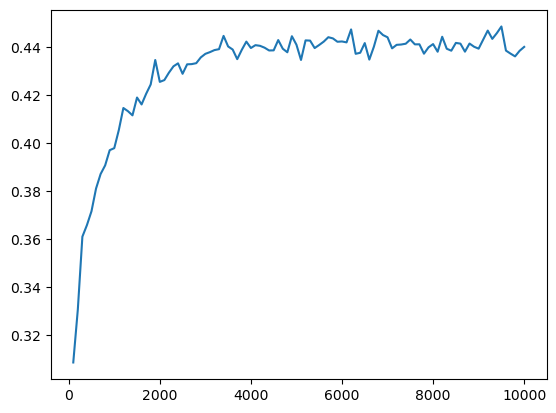

In [16]:
fig,ax = plt.subplots()
ax.plot(range(100,10001,100), accs)

In [17]:
# we are really trying everythign here to get an accuracy above the 0.40's